# Рекомендательная система

В данном проекте мы рассмотрим основные этапы создания рекомендательной системы интернет-магазина.

Основной целью проекта является изучение принципов работы рекомендательных систем, знакомство с различными алгоритмами и создание прототипа.

В ходе работы над проектом были решены следующие задачи:

1) EDA - разведывательный анализ данных

2) Предобработка данных и генерация новых признаков

3) Обучение простой модели LightFM

4) Решение проблемы холодного старта путём добавления item_features и user_features: https://www.kaggle.com/fedorazarov/project-20-group-1-fa-hybrid

5) Реализация рекомендательной системы с помощью бибилиотеки fast.ai: https://www.kaggle.com/fedorazarov/project-20-group-1-fa-fastai-collablearner

6) Создание прототипа

# Подготовка данных

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import json
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Загружаем датасеты
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

# Постройчно прочитаем json с метаданными и положим результат в датасет "meta"
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

# Объединим тренировочный датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)
df_new_train = pd.merge(train, meta, on='asin')

/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/sample_submission.csv


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Посмотрим для начала на тестовый и тренировочный датасеты

In [2]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Dat

Видим, что в тренировочном датасете на три столбца больше:
* присутствует overall - оценка по пятибальной шкале
* присутствует reviewText - текст отзыва
* присутствует summary - краткое содержание отзыва
* присутствует rating - целевая переманная
* отсутствует Id

Создадим копию расширенного датасета df_new, чтобы каждый раз заново не загружать данные, если что-то испортим.

In [3]:
df = df_new_train.copy()

# EDA

Посмотрим на датасет

In [4]:
df.head(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,5.0,False,"05 18, 2016",B01CPNIEQG,A. Yeager,I have loved adobo seasoning for years. Once I...,I have loved adobo seasoning for years,1463529600,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
4,5.0,False,"05 18, 2016",B01CPNIEQG,LuvstoShop,I love this blend. It makes my hashbrowns! So ...,Five Stars,1463529600,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

Всего 30 признаков. 1 бинарный, 5 числовых и 24 категориальных. Пройдемся по признакам.

Напишем функцию, которая выдаст нам необходимую информацию для первичного анализа признака.

In [6]:
# Функция без гистограммы
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))

# Функция с гистограммой
def col_info_hist(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()

## Overall

Количество пропусков: 0,
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64,


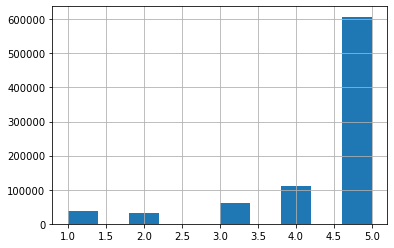

In [7]:
col_info_hist(df.overall)

Похоже на оценку по пятибальной шкале. Подавляющее большинство - пятерки. Данного признака нет в тестовой выборке, но мы можем использовать его для анализа других признаков.[](http://)

In [8]:
df['overall']=df['overall'].astype('int32')

## verified

In [9]:
col_info(df.verified)

Количество пропусков: 0,
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object,
Распределение:
True     736369
False    111224
Name: verified, dtype: int64,


Данный признак скорее всего означает, что либо комментарий, либо аккаунт пользователя подтвержден. Пропусков нет.
Заменим значения на 1 и 0.

In [10]:
dic_verified = {
    True: 1,
    False: 0
}
df['verified'] = df['verified'].map(dic_verified)

Посмотрим, как влияет признак verified на среднюю оценку.

Средняя оценка при значении verified = 1:  4.479455273103566
Средняя оценка при значении verified = 0:  4.186920089189384


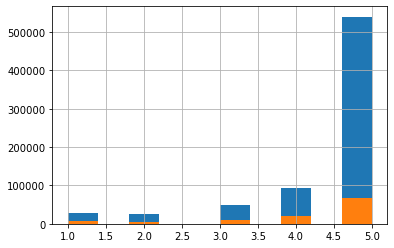

In [11]:
print('Средняя оценка при значении verified = 1: ',df[df.verified == 1].overall.mean())
df['overall'][df['verified'] == 1].hist(bins=10)
print('Средняя оценка при значении verified = 0: ',df[df.verified == 0].overall.mean())
df['overall'][df['verified'] == 0].hist(bins=10)

Видим, что средняя оценка товаров с признаком verified = 1 выше, но в целом распределение оценок похожее.

## reviewTime

In [12]:
col_info(df.reviewTime)

Количество пропусков: 0,
count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object,
Распределение:
03 1, 2016     941
07 14, 2016    873
01 20, 2016    783
06 3, 2015     783
02 20, 2016    767
              ... 
06 4, 2006       1
06 25, 2004      1
11 21, 2006      1
04 27, 2006      1
07 26, 2007      1
Name: reviewTime, Length: 4580, dtype: int64,


Дата отзыва. Эта информация есть в колонке unixReviewTime в более удобном формате. Удалим данный столбец.

In [13]:
df = df.drop(['reviewTime'], axis=1)

## reviewerName

In [14]:
col_info(df.reviewerName)

Количество пропусков: 168,
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer     31346
Kindle Customer      6128
Linda                 729
John                  714
David                 606
                    ...  
Pamela R. Bone          1
Roger Gardner           1
forrest73               1
American -Bonsai        1
cpnut                   1
Name: reviewerName, Length: 101207, dtype: int64,


Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Проверим, один userid у Amazon Customer, или одному имени пользователя может соответствовать несколько userid.

In [15]:
df[df.reviewerName=='Amazon Customer'].userid.value_counts()

7477      91
1330      60
24035     55
8027      53
15752     44
          ..
73871      1
115807     1
58045      1
62767      1
65437      1
Name: userid, Length: 5329, dtype: int64

В таком случае, имя пользователя нам не нужно. Удалим столбец.

In [16]:
df = df.drop(['reviewerName'], axis=1)

## reviewText

In [17]:
print('Количество пропусков: {},'.format(df.reviewText.isnull().sum()))

Количество пропусков: 278,


Посмотрим на пример отзыва

In [18]:
df.reviewText[25]

"What's not to love, its Swiss Miss Hot Cocoa, not much to say. It is delicious, not the healthiest thing in the world but its chocolate. I have it every morning in my coffee with a bit of milk, it is how I treat myself in the A.M.\n\nLove this stuff and always have!!!"

Выделим из всех отзывов наиболее часто встречающиеся слова.

ВНИМАНИЕ!!! Весь код, который закомменчен ниже в ноутбуке рабочий, в результате генерируется большое количество dummy-переменных. На этапе тестирования код закомментирован для скорости, при желании добавить новые фичи уберите комментарии.

In [19]:
'''
# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 200

# Приведем значения к str
df['reviewText']=df['reviewText'].astype('str')
# Разбиваем reviewText на список слов, предварительно приводим текст к нижнему регистру
df['reviewText']=df['reviewText'].apply(lambda x: re.sub("[^\w]", " ",  x.lower()).split())
                                        
# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in df.reviewText:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] +=1
    
#Оставим топ N_WORDS слов
top_words = []
for i in range (0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)
    
# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ',top_words)'''

'\n# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить\nN_WORDS = 200\n\n# Приведем значения к str\ndf[\'reviewText\']=df[\'reviewText\'].astype(\'str\')\n# Разбиваем reviewText на список слов, предварительно приводим текст к нижнему регистру\ndf[\'reviewText\']=df[\'reviewText\'].apply(lambda x: re.sub("[^\\w]", " ",  x.lower()).split())\n                                        \n# Создаем пустой список, в который будут добавляться все слова\nall_words = []\n\n# Добавляем слова каждой записи в общий список\nfor words in df.reviewText:\n    # разбиваем текст на слова, предварительно приводим к нижнему регистру\n    all_words.extend(words)\n\n# Считаем частоту слов в датасете\ncnt = Counter()\nfor word in all_words:\n    cnt[word] +=1\n    \n#Оставим топ N_WORDS слов\ntop_words = []\nfor i in range (0, len(cnt.most_common(N_WORDS))):\n    words = cnt.most_common(N_WORDS)[i][0]\n    top_words.append(words)\n    \n# Удаляем дубликаты из all_words\nal

Среди самых частых слов много предлогов и артиклей. Отберем вручную список из 50 значимых по нашему мнению слов.

In [20]:
top_word_list = [
    'good',
    'great',
    'like',
    'so',
    'taste',
    'very',
    'flavor',
    'love',
    'tea',
    'product',
    'coffee',
    'more',
    'really',
    'price',
    'much',
    'buy',
    'best',
    'make',
    'time',
    'sugar',
    'little',
    'delicious',
    'only',
    'chocolate',
    'better',
    'again',
    'well',
    'nice',
    'tastes',
    'sweet',
    'fresh',
    'favorite',
    'eat',
    'cup',
    'now',
    'quality',
    'tasty',
    'salt',
    'organic',
    'brand',
    'flavors',
    'oil',
    'perfect',
    'first',
    'order',
    'many',
    'box',
    'mix',
    'always',
    'hot',
]

Далее мы можем оставить только самые популярные слова и создать на их основе dummy-переменные.

**Я пока что закомментировал создание dummy-переменных для самых частых слов. Если хотите с ними обучить модель, то код ниже рабочий**

In [21]:
'''# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит
def leave_top_words(words):
    top_words = []
    for word in words:
        if word in top_word_list:
            top_words.append(word)
    x = top_words
    return x

# Применим функцию к датасету, оставим только слова из top_word_list в столбце reviewText
df['reviewText'] = df['reviewText'].apply(lambda x: leave_top_words(x))


# Создание dummy-переменных на основе слов из top_word_list

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1
for item in top_word_list:
    column_name = 'reviewText_' + item
    df[column_name] = df['reviewText'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит\ndef leave_top_words(words):\n    top_words = []\n    for word in words:\n        if word in top_word_list:\n            top_words.append(word)\n    x = top_words\n    return x\n\n# Применим функцию к датасету, оставим только слова из top_word_list в столбце reviewText\ndf['reviewText'] = df['reviewText'].apply(lambda x: leave_top_words(x))\n\n\n# Создание dummy-переменных на основе слов из top_word_list\n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1\nfor item in top_word_list:\n    column_name = 'reviewText_' + item\n    df[column_name] = df['reviewText'].apply(find_item)"

Поздно заметил, что данного признака нет в тестовой выборке, но было жалко удалять труд. Хорошо, что наработки понадобились дальше.
Удалим столбец.

In [22]:
# Удалим столбец reviewText
df = df.drop(['reviewText'], axis=1)

## summary

In [23]:
df.summary[25]

'Classic hot chocolate'

Данного признака нет в тестовом датасете. Удалим столбец.

In [24]:
df = df.drop(['summary'], axis=1)

## asin

идентификатор для модели нам не нужен, но у нас есть признаки also_buy и similar_item, для которых он может понадобиться. Пока оставим.

In [25]:
col_info(df.asin)

Количество пропусков: 0,
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object,
Распределение:
B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B001684NXK       1
B006UCU89U       1
B000O6IBQ0       1
B001GE4CKI       1
B000SUKHZ0       1
Name: asin, Length: 41302, dtype: int64,


Видим, что всего у нас 41302 различных продукта.

В дальнейшем мы этот признак не используем т.к. пока не придумали как использовать признаки also_view и also_buy, для которых asin скорее всего понадобится.
Пока что удалим.

In [26]:
df = df.drop(['asin'], axis=1)

## unixReviewTime

In [27]:
col_info(df.unixReviewTime)

Количество пропусков: 0,
count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1113782400      1
1132444800      1
1167609600      1
1105142400      1
1155081600      1
Name: unixReviewTime, Length: 4580, dtype: int64,


Пропусков нет. Посмотрим, как изменялись оценки со временем.

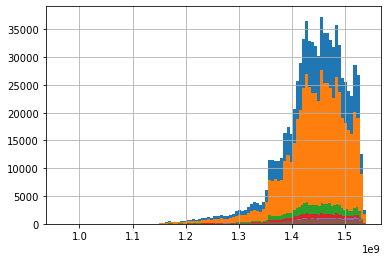

In [28]:
df.unixReviewTime.hist(bins=100)
df[df.overall == 5].unixReviewTime.hist(bins=100)
df[df.overall == 4].unixReviewTime.hist(bins=100)
df[df.overall == 3].unixReviewTime.hist(bins=100)
df[df.overall == 1].unixReviewTime.hist(bins=100)
df[df.overall == 2].unixReviewTime.hist(bins=100)

Посмотрим, на распределение отзывов по датам, приведя даты к удобному виду.

In [29]:
from datetime import datetime
tsmin = df.unixReviewTime.min()
ts25 = int(df.unixReviewTime.quantile(0.25))
ts50 = int(df.unixReviewTime.quantile(0.50))
ts75 = int(df.unixReviewTime.quantile(0.75))
tsmax = df.unixReviewTime.max()
print('Самый первый отзыв:', datetime.utcfromtimestamp(tsmin).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(ts25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(ts50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(ts75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(tsmax).strftime('%Y-%m-%d %H:%M:%S'))

Самый первый отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-10-01 00:00:00
50 квантиль: 2015-12-06 00:00:00
75 квантиль: 2017-01-23 00:00:00
Последний отзыв: 2018-10-02 00:00:00


Создадим категории в зависимости от даты написания отзыва

In [30]:
# Создадим 3 категории в зависимости от даты написания
def cat_date(x):
    if x <= ts25: x = 'old'
    elif ts25 < x <= ts50: x = 'middle_old'
    elif ts50 < x <= ts75: x = 'middle_new'
    elif ts75 < x: x = 'new'
    return x      

# Заменим значения в столбце на категории
df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: cat_date(x))

Создание dummy-переменных сделаем позже.

## vote

In [31]:
col_info(df.vote)

Количество пропусков: 728732,
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64,
Распределение:
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
387.0        1
393.0        1
402.0        1
404.0        1
203.0        1
Name: vote, Length: 477, dtype: int64,


In [32]:
df.vote.unique()

array([nan, 4.0, 5.0, 8.0, '7', 7.0, 3.0, 2.0, '28', '2', '4', 6.0, '3',
       '30', '14', '8', '6', '17', '5', '142', '21', '16', 9.0, 15.0,
       12.0, 18.0, 404.0, 22.0, 10.0, '22', 13.0, 136.0, '18', '12', '34',
       '69', '10', '48', '20', 11.0, 14.0, 133.0, 16.0, 36.0, 31.0, 117.0,
       17.0, 29.0, 37.0, '39', '9', '11', '27', 172.0, 251.0, '41', 52.0,
       38.0, 27.0, '15', '61', '38', 25.0, 127.0, '36', 28.0, 61.0, 24.0,
       49.0, 51.0, 19.0, 20.0, '13', 74.0, 121.0, 45.0, 33.0, 266.0, '44',
       '232', '25', 47.0, 138.0, 176.0, 75.0, 30.0, '42', 128.0, '24',
       '184', '624', 40.0, 272.0, 881.0, 53.0, 21.0, 43.0, 184.0, '35',
       35.0, 23.0, 39.0, 227.0, 42.0, 507.0, 59.0, 114.0, 87.0, 55.0,
       26.0, '19', 41.0, '82', 143.0, 73.0, 187.0, 66.0, '45', 56.0, '76',
       112.0, 57.0, '115', '75', '33', '50', 50.0, 68.0, 54.0, 63.0, '47',
       '43', 108.0, 185.0, '302', 208.0, '59', 269.0, 78.0, 103.0, '26',
       148.0, 160.0, '80', 32.0, 71.0, 130.0, 85

Скорее всего, данные признак показывает количество голосов, отданных за отзыв.
Видим, что в значениях числа через запятую, с нулём и без нуля. Также видим большое количество пропусков. 
Скорее всего, за эти отзывы никто не проголосовал, что вполне естественно, и мы можем заменить пропуски на 0.

In [33]:
# Заменим пропуски на 0
df.vote = df.vote.fillna(0)

In [34]:
# Удалим запятые
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
# Заменим пропуски на 0
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
# Приведем к int32
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')
# Посмотрим на результат
df.vote.unique()

array([   0,    4,    5,    8,    7,    3,    2,   28,    6,   30,   14,
         17,  142,   21,   16,    9,   15,   12,   18,  404,   22,   10,
         13,  136,   34,   69,   48,   20,   11,  133,   36,   31,  117,
         29,   37,   39,   27,  172,  251,   41,   52,   38,   61,   25,
        127,   24,   49,   51,   19,   74,  121,   45,   33,  266,   44,
        232,   47,  138,  176,   75,   42,  128,  184,  624,   40,  272,
        881,   53,   43,   35,   23,  227,  507,   59,  114,   87,   55,
         26,   82,  143,   73,  187,   66,   56,   76,  112,   57,  115,
         50,   68,   54,   63,  108,  185,  302,  208,  269,   78,  103,
        148,  160,   80,   32,   71,  130,   85,  123,   62,   95,  603,
         88,   86,  132,   67,  119,   70,  296,  560,   91,   46,  203,
        360,  857,  107,  679,  146,   89,   60,   94,   77,  129,  122,
        223,  100,   65,  101,   64,  255,  116,  171,  276,  186,  190,
        531,  166, 1157,  435,  516,  416,  173,   

Сделаем признак категориальным. Выделим 3 категории по количеству голосов.

In [35]:
# Создадим 3 категории по количеству голосов
def cat_vote(x):
    if x < 10: x = 'low'
    elif 10 <= x <= 100: x = 'middle'
    elif 100 < x: x = 'high'
    return x      

# Заменим значения в столбце на категории
df['vote'] = df['vote'].apply(lambda x: cat_vote(x))

dummy-переменные создадим после EDA

# style

In [36]:
col_info(df['style'])

Количество пропусков: 407242,
count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object,
Распределение:
{'Size:': ' Pack of 1'}                                               4856
{'Package Quantity:': ' 1'}                                           4526
{'Package Type:': ' Standard Packaging'}                              3898
{'Size:': ' 1 Pack'}                                                  3848
{'Size:': ' 24 Count'}                                                3640
                                                                      ... 
{'Size:': ' 12 ct', 'Flavor:': ' Smile Jamaica'}                         1
{'Size:': ' 4 Ounce', 'Flavor:': ' Lady Londonderry Tea Pouches'}        1
{'Size:': ' 6 Count', 'Flavor:': ' Original Soft Caramel'}               1
{'Flavor:': ' Ice Coffee'}                                               1
{'Size:': ' 10.6 OZ - Pack of 3', 'Flavor

Видим словарь из размера упаковки и вкуса. Скорее всего, отсюда можно что-то полезное выделить, но но пропусков больше половины. Займемся если останется время.

In [37]:
df = df.drop(['style'], axis=1)

## image_x

Ссылки на картинки. Удалим столбец.

In [38]:
df = df.drop(['image_x'], axis=1)

## userid

In [39]:
col_info(df.userid)

Количество пропусков: 0,
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64,
Распределение:
842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64,


ID пользователя. Пропусков нет, идем дальше.

## itemid

In [40]:
col_info(df.itemid)

Количество пропусков: 0,
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64,
Распределение:
22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38965       1
23635       1
34272       1
39917       1
38902       1
Name: itemid, Length: 41302, dtype: int64,


Проверим, если в тестовом и тренировочном датасетах пропущенные id. Это может быть проблемой при предсказании с помощьюу LightFM c item_features.

In [41]:
print('Количество уникальных itemid в тренировочном датасете:',len(df.itemid.unique()))
print('Максимальный itemid в тренировочном датасете:',df.itemid.max()+1)

Количество уникальных itemid в тренировочном датасете: 41302
Максимальный itemid в тренировочном датасете: 41320


Видим, что есть пропущенные itemid. Подумаем, что с этим делать после eda.

In [42]:
df.head(1)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,category,description,title,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5,1,middle_new,low,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


ID товара. Пропусков нет.

## rating

In [43]:
col_info(df.rating)

Количество пропусков: 0,
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,
Распределение:
1.0    719392
0.0    128201
Name: rating, dtype: int64,


Целевая переменная. Здесь всего 2 значения - понравился пользователю товар или нет.
Посмотрим, как этот признак зависит от оценки.

In [44]:
print('Оценки при rating = 0:\n', df[df.rating == 0].overall.value_counts())
print('Оценки при rating = 1:\n', df[df.rating == 1].overall.value_counts())

Оценки при rating = 0:
 3    59795
1    37071
2    31335
Name: overall, dtype: int64
Оценки при rating = 1:
 5    607524
4    111868
Name: overall, dtype: int64


При оценках 4 или 5 считаем, что товар понравился. 1,2 или 3 - не понравился.

## category

In [45]:
df.category[25]

['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Cocoa']

Видим в данном признаке список категорий, к которй относится товар.
Посмотрим, сколько всего категорий и выделим самые популярные.

In [46]:
'''# Зададим переменной количество категорий
N_CATS = 500

# Создаем пустой список, в который будут добавляться все категории
all_categories = []

# Добавляем категории каждой записи в общий список
for category in df.category:
    all_categories.extend(category)

# Считаем частоту категорий в датасете
cnt = Counter()
for word in all_categories:
    cnt[word] +=1
    
#Оставим топ N_CATS категорий
top_cat = []
for i in range (0, len(cnt.most_common(N_CATS))):
    cat = cnt.most_common(N_CATS)[i][0]
    top_cat.append(cat)
    
# Удаляем дубликаты из all_categories
all_categories = list(dict.fromkeys(all_categories))

print('Всего категорий: ', len(all_categories))
print('Топ', N_CATS, 'категорий: ',top_cat)'''

"# Зададим переменной количество категорий\nN_CATS = 500\n\n# Создаем пустой список, в который будут добавляться все категории\nall_categories = []\n\n# Добавляем категории каждой записи в общий список\nfor category in df.category:\n    all_categories.extend(category)\n\n# Считаем частоту категорий в датасете\ncnt = Counter()\nfor word in all_categories:\n    cnt[word] +=1\n    \n#Оставим топ N_CATS категорий\ntop_cat = []\nfor i in range (0, len(cnt.most_common(N_CATS))):\n    cat = cnt.most_common(N_CATS)[i][0]\n    top_cat.append(cat)\n    \n# Удаляем дубликаты из all_categories\nall_categories = list(dict.fromkeys(all_categories))\n\nprint('Всего категорий: ', len(all_categories))\nprint('Топ', N_CATS, 'категорий: ',top_cat)"

Далее мы можем оставить только самые популярные категории и создать на их основе dummy-переменные.

**Я пока что закомментировал создание dummy-переменных для топовых категорий. Если хотите с ними обучить модель, то код ниже рабочий**

In [47]:
'''# Напишем функцию, которая будет оставлять только топовые категории в списке, остальные удалит
def top_category(categories):
    top_categories = []
    for category in categories:
        if category in top_cat:
            top_categories.append(category)
    x = top_categories
    return x

# Применим функцию к датасету, оставим только топовые категории в стольце category
df['category'] = df['category'].apply(lambda x: top_category(x))


# Создание dummy-переменных на основе топовых категорий 

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с категориями и заполняем 0 или 1
for item in top_cat:
    column_name = 'category' + item
    df[column_name] = df['category'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять только топовые категории в списке, остальные удалит\ndef top_category(categories):\n    top_categories = []\n    for category in categories:\n        if category in top_cat:\n            top_categories.append(category)\n    x = top_categories\n    return x\n\n# Применим функцию к датасету, оставим только топовые категории в стольце category\ndf['category'] = df['category'].apply(lambda x: top_category(x))\n\n\n# Создание dummy-переменных на основе топовых категорий \n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы с категориями и заполняем 0 или 1\nfor item in top_cat:\n    column_name = 'category' + item\n    df[column_name] = df['category'].apply(find_item)"

In [48]:
# Удалим столбец с категориями
df = df.drop(['category'], axis = 1)

## description

In [49]:
df.description[115]

['Torani Vanilla Syrup, Sugar Free, 25.4 Fl Oz',
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']

Cделаем то же самое, что мы делали для признака reviewText: найдем самые часто встречающиеся слова, оставим только их и подготовимся к созданию dummy-переменных.

In [50]:
'''# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 200

# Сейчас в поле description список строк. Приведем к единой строке.
df['description']=df['description'].astype('str')

# Разбиваем description на список слов, предварительно приводим текст к нижнему регистру
df['description']=df['description'].apply(lambda x: re.sub("[^\w]", " ",  x.lower()).split())
                                        
# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in df['description']:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] +=1
    
#Оставим топ N_WORDS слов
top_words = []
for i in range (0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)
    
# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ',top_words)'''

'# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить\nN_WORDS = 200\n\n# Сейчас в поле description список строк. Приведем к единой строке.\ndf[\'description\']=df[\'description\'].astype(\'str\')\n\n# Разбиваем description на список слов, предварительно приводим текст к нижнему регистру\ndf[\'description\']=df[\'description\'].apply(lambda x: re.sub("[^\\w]", " ",  x.lower()).split())\n                                        \n# Создаем пустой список, в который будут добавляться все слова\nall_words = []\n\n# Добавляем слова каждой записи в общий список\nfor words in df[\'description\']:\n    # разбиваем текст на слова, предварительно приводим к нижнему регистру\n    all_words.extend(words)\n\n# Считаем частоту слов в датасете\ncnt = Counter()\nfor word in all_words:\n    cnt[word] +=1\n    \n#Оставим топ N_WORDS слов\ntop_words = []\nfor i in range (0, len(cnt.most_common(N_WORDS))):\n    words = cnt.most_common(N_WORDS)[i][0]\n    top_words.appe

Среди самых частых слов много предлогов и артиклей. Отберем вручную список из 50 значимых по нашему мнению слов.

In [51]:
top_word_list = [
    'health',
    'treat',
    'intended',
    'disease',
    'prevent',
    'cure',
    'dietary',
    'diagnose',
    'evaluated',
    'statements',
    'condition',
    'supplements',
    'fda',
    'organic',
    'flavor',
    'tea',
    'natural',
    'sugar',
    'salt',
    'water',
    'oil',
    'coffee',
    'ingredients',
    'milk',
    'free',
    'products',
    'chocolate',
    'taste',
    'cup',
    'delicious',
    'quality',
    'flavors',
    'soy',
    'food',
    'flour',
    'acid',
    'wheat', 
    'great',
    'powder',
    'corn',
    'nuts',
    'rice',
    'protein',
    'coconut',
    'gluten',
    'butter',
    'syrup',
    'blend',
    'high',
    'best'
]

Далее мы можем оставить только самые популярные слова и создать на их основе dummy-переменные.

**Я пока что закомментировал создание dummy-переменных для самых частых слов. Если хотите с ними обучить модель, то код ниже рабочий**

In [52]:
'''# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит
def leave_top_words(words):
    top_words = []
    for word in words:
        if word in top_word_list:
            top_words.append(word)
    x = top_words
    return x

# Применим функцию к датасету, оставим только слова из top_word_list в столбце description
df['description'] = df['description'].apply(lambda x: leave_top_words(x))


# Создание dummy-переменных на основе слов из top_word_list

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1
for item in top_word_list:
    column_name = 'description' + item
    df[column_name] = df['description'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит\ndef leave_top_words(words):\n    top_words = []\n    for word in words:\n        if word in top_word_list:\n            top_words.append(word)\n    x = top_words\n    return x\n\n# Применим функцию к датасету, оставим только слова из top_word_list в столбце description\ndf['description'] = df['description'].apply(lambda x: leave_top_words(x))\n\n\n# Создание dummy-переменных на основе слов из top_word_list\n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1\nfor item in top_word_list:\n    column_name = 'description' + item\n    df[column_name] = df['description'].apply(find_item)"

In [53]:
df = df.drop(['description'], axis = 1)

## title

In [54]:
df.title[115]

'Torani Syrup, Sugar Free Vanilla, 25.4 oz'

Видим, что title частично содержится в description. Удалим данный признак.

In [55]:
df = df.drop(['title'], axis = 1)

## brand

In [56]:
col_info(df.brand)

Количество пропусков: 6104,
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object,
Распределение:
KIND                     22506
Bob's Red Mill           13061
Twinings                 11182
Planters                 10384
Frontier                  6926
                         ...  
LOU'S BONSAI  NURSERY        1
Drumstick                    1
Sugar                        1
Liberty                      1
Caffe Vita                   1
Name: brand, Length: 8866, dtype: int64,


Пропусков относительно не много. 8866 разных производителей. Можно выделить самых известных и сделать для них dummy-переменные, как мы делали для других категориальных признаков.

In [57]:
'''# Зададим переменной количество производителей
N_BRANDS = 50

# Приведем к str
df['brand']=df['brand'].astype('str')

# Создаем пустой список, в который будут добавляться все производители
all_brands = []

# Добавляем производителя из каждой записи в общий список
for brand in df.brand:
    all_brands.append(brand)

# Считаем количество производителей в датасете
cnt = Counter()
for word in all_brands:
    cnt[word] +=1
    
#Оставим топ N_BRANDS производителей
top_brand = []
for i in range (0, len(cnt.most_common(N_BRANDS))):
    br = cnt.most_common(N_BRANDS)[i][0]
    top_brand.append(br)
    
# Удаляем дубликаты из all_brands
all_brands = list(dict.fromkeys(all_brands))

print('Всего производителей: ', len(all_brands))
print('Топ', N_BRANDS, 'производителей: ',top_brand)'''

"# Зададим переменной количество производителей\nN_BRANDS = 50\n\n# Приведем к str\ndf['brand']=df['brand'].astype('str')\n\n# Создаем пустой список, в который будут добавляться все производители\nall_brands = []\n\n# Добавляем производителя из каждой записи в общий список\nfor brand in df.brand:\n    all_brands.append(brand)\n\n# Считаем количество производителей в датасете\ncnt = Counter()\nfor word in all_brands:\n    cnt[word] +=1\n    \n#Оставим топ N_BRANDS производителей\ntop_brand = []\nfor i in range (0, len(cnt.most_common(N_BRANDS))):\n    br = cnt.most_common(N_BRANDS)[i][0]\n    top_brand.append(br)\n    \n# Удаляем дубликаты из all_brands\nall_brands = list(dict.fromkeys(all_brands))\n\nprint('Всего производителей: ', len(all_brands))\nprint('Топ', N_BRANDS, 'производителей: ',top_brand)"

Далее мы можем оставить только самых популярных производителей и создать на их основе dummy-переменные.

**Я пока что закомментировал создание dummy-переменных для топовых категорий. Если хотите с ними обучить модель, то код ниже рабочий**

In [58]:
'''# Напишем функцию, которая будет оставлять только топовых производителей, остальных удалит
def leave_top_brand(brands):
    top_brands = []
    for brand in brands:
        if brand in top_brand:
            top_brands.append(brand)
    x = top_brands
    return x

# Применим функцию к датасету, оставим только топовых производителей в стольце brand
df['brand'] = df['brand'].apply(lambda x: leave_top_brand(x))


# Создание dummy-переменных на основе топовых производителей 

# Функция для отображения производителей в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с производителями и заполняем 0 или 1
for item in top_brand:
    column_name = 'brand_' + item
    df[column_name] = df['brand'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять только топовых производителей, остальных удалит\ndef leave_top_brand(brands):\n    top_brands = []\n    for brand in brands:\n        if brand in top_brand:\n            top_brands.append(brand)\n    x = top_brands\n    return x\n\n# Применим функцию к датасету, оставим только топовых производителей в стольце brand\ndf['brand'] = df['brand'].apply(lambda x: leave_top_brand(x))\n\n\n# Создание dummy-переменных на основе топовых производителей \n\n# Функция для отображения производителей в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы с производителями и заполняем 0 или 1\nfor item in top_brand:\n    column_name = 'brand_' + item\n    df[column_name] = df['brand'].apply(find_item)"

In [59]:
df = df.drop(['brand'], axis = 1)

## rank

In [60]:
print('Количество пропусков: {},'.format(df['rank'].isnull().sum()))

Количество пропусков: 34598,


Посмотрим, как выглядят значения

In [61]:
df['rank'][1]

'19,771inGroceryGourmetFood('

Приведем значения данного признака к единому числовому виду

In [62]:
# Приведем все к str
df['rank'] = df['rank'].astype('str')
# Удалим все значения кроме числовых
df['rank'] = df['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг (предположим, что чем ниже ранг, тем лучше)
df['rank'] = df['rank'].apply(lambda x: 9999999 if x == '' else x)
df['rank'] = df['rank'].astype('float')
# Остаются какие-то большие значения, заменим их на высокий ранг
df['rank'] = df['rank'].apply(lambda x: 9999999 if x > 9999999 else x)
df['rank'] = df['rank'].astype('int32')
# Посмотрим на результат
col_info(df['rank'])

Количество пропусков: 0,
count    8.475930e+05
mean     6.676660e+05
std      2.289290e+06
min      4.000000e+00
25%      1.094000e+04
50%      4.999900e+04
75%      1.799160e+05
max      9.999999e+06
Name: rank, dtype: float64,
Распределение:
9999999    47163
18          7421
4575        4733
2949        4611
142261      4252
           ...  
1169810        1
784450         1
293005         1
265756         1
643797         1
Name: rank, Length: 35977, dtype: int64,


Заменим значения на категории. Создание dummy-переменных сделаем после EDA

In [63]:
# Создадим 3 категории рангов
def cat_rank(x):
    if x < 1093: x = 'high'
    elif 1093 <= x <= 18000: x = 'middle'
    elif 18000 < x: x = 'low'
    return x      

# Заменим значения в столбце на категории
df['rank'] = df['rank'].apply(lambda x: cat_rank(x))

## also_view

In [64]:
df.also_view[127]

['B006K3UC86', 'B000WGB3OY']

Видим список других товаров в виде asin.

В качестве идеи: 
* так же как мы делали для категорий, посчитать количество упоминаний каждого товара
* сделать числовой признак in_also_view, в котором будет указано, сколько каждый товар упоминается в других товарах в also_view

* сделать как с категориями - dummy-переменные для само часто упоминаемых в also_view товарах

Однако мы уже явно выбиваемся за отведенные на задание 8 часов. Удалим признак.

In [65]:
df = df.drop(['also_view'], axis = 1)

## main_cat

In [66]:
col_info(df.main_cat)

Количество пропусков: 955,
count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object,
Распределение:
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Musical Instruments               3
Software                          3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64,


Избавимся от пропусков. dummy-переменные для категорий создадим после EDA.

In [67]:
# Заменим пропуски на категорию "Other"
df.main_cat = df.main_cat.fillna('Other')

## price

In [68]:
col_info(df.price)

Количество пропусков: 258621,
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object,
Распределение:
$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$92.52                  2
$44.14                  1
$6.93                   1
$35.16                  1
$19.99 - $295.00        1
Name: price, Length: 4601, dtype: int64,


У нас довольно много пропусков и есть диапозоны цен, например 19.99-295.00.
Заменим такие значения и пропуски на среднее значение.
Чтобы найти среднее значение, создадим вспомогательный датасет, удалим в нем пропуски в столбце price и посчитаем среднее.

In [69]:
# Скопируем датасет
df_price = df.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Приведем все к str
df_price['price'] = df_price['price'].astype('str')
# Удалим все значения кроме числовых
df_price['price'] = df_price['price'].apply(lambda x: re.sub('\D', '', x))
# Переведем во float
df_price['price'] = df_price['price'].astype('float')
# Удалим все, что дороже 9999$ т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < 999999]
# Посмотрим на результат
col_info(df_price.price)

Количество пропусков: 0,
count    585001.000000
mean       2069.952270
std        1754.135664
min           1.000000
25%        1155.000000
50%        1691.000000
75%        2599.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
1499.0    14241
1367.0    10660
1999.0     9043
1479.0     5632
1553.0     5561
          ...  
2504.0        2
2848.0        2
693.0         1
4414.0        1
3516.0        1
Name: price, Length: 4527, dtype: int64,


На вид все ОК. Теперь мы можем сделать похожую процедуру для основного датасета, заменив нулевые значения и диапазоны цен на среднюю цену.

In [70]:
# Чтобы каждый раз не считать среднее значение, используем переменную
df_price_mean = df_price.price.mean()
# Приведем все к str
df['price'] = df['price'].astype('str')
# Удалим все значения кроме числовых
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на среднее значение
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x == '' else x)
# Приведем к float
df['price'] = df['price'].astype('float')
# Заменим большие значения на средние
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x > 999999 else x)
# Приведем к int32
df['price'] = df['price'].astype('int32')
# Смотрим на результат
col_info(df.price)

Количество пропусков: 0,
count    847593.000000
mean       2069.967057
std        1457.295712
min           1.000000
25%        1398.000000
50%        2070.000000
75%        2112.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
2070    262805
1499     14241
1367     10660
1999      9043
1479      5632
         ...  
3552         2
4906         2
693          1
3516         1
4414         1
Name: price, Length: 4527, dtype: int64,


Поделим цены на 3 категории и создадим dummy-переменные

In [71]:
def cat_price(x):
    if x < 1397: x = 'low'
    elif 1397 <= x <= 2099: x = 'middle'
    elif 2099 < x: x = 'high'
    return x      

df['price'] = df['price'].apply(lambda x: cat_price(x))

Cоздадим dummy-переменные после EDA

## also_buy

In [72]:
print(df.also_buy[25])

['B001FBKO4U', 'B00BJ9URYA', 'B00451ZJB0', 'B0017TMTFM', 'B005H0H6VO', 'B003VTLR5Y', 'B004AJNTTG', 'B00281PIBA', 'B009GJFBOG', 'B00ESMAR4K', 'B0797BZK8L', 'B0030LILPM', 'B00284TRPA', 'B00FZW1B3I', 'B008YX9DBM', 'B000YUOY30', 'B07D83WGWN', 'B079TR46SP', 'B00I5I2ZYI', 'B00006IDJX', 'B00WT4ZC12', 'B00286KM8E', 'B00CAC6XBG', 'B002W90JJY', 'B01N65U0R6', 'B004JUZ502', 'B00GEG40KA', 'B076D91YKH', 'B0010XVRXK', 'B001UBLV1K', 'B00IZC4ZJC', 'B00BKUULEO', 'B0023XKXEA', 'B079K6ZQMJ', 'B00KO3O1BC', 'B00HT91ZPY', 'B00F2PD92O', 'B00BFUFYZK', 'B007JKN0R4', 'B01FF96B94', 'B072DVZRN1', 'B01N6CKOXH', 'B007ZNE5WE', 'B00UII9OEC', 'B0040ZFAQ0', 'B0040ZOVTW', 'B0019QW0CU', 'B00284TOOY', 'B002SQJI98', 'B076MBL7PS', 'B071HM5WC9', 'B004NG8DFQ', 'B00ICT73A6', 'B01LYHE49W', 'B004E2O5T2', 'B008GVJ9S4', 'B00196T0LE', 'B00O3IQJ2I', 'B008O7LUQY', 'B0745HFZLV', 'B076TP8D8X', 'B0016BS29S', 'B001IZG8D4', 'B00XTS39EE', 'B00J0EKV3I', 'B01IPCE0A0', 'B0038ZWUKC', 'B000FOIYS6', 'B0040ZFRSQ', 'B00F2PCKQK', 'B001GM60LE', 'B072

аналогично also_view. Есть идеи, что с этим сделать, но уже давно пора переходить к следующим этапам. Пока что удалим.

In [73]:
df = df.drop(['also_buy'], axis = 1)

## image_y

In [74]:
df.image_y[0]

['https://images-na.ssl-images-amazon.com/images/I/51gJ78gwiuL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Atu6eGDGL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51IVforY1EL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51TVXVBrfbL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Prc170IBL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/316wiuQhBFL._SS40_.jpg']

Картинки - удаляем

In [75]:
df = df.drop(['image_y'], axis = 1)

## date

In [76]:
col_info(df.date)

Количество пропусков: 835506,
count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object,
Распределение:
January 1, 2006      561
May 5, 2003          428
October 29, 2003     424
January 7, 2008      372
March 10, 2004       294
                    ... 
December 22, 2007      2
August 2, 2008         2
February 21, 2015      1
January 18, 2008       1
February 13, 2008      1
Name: date, Length: 417, dtype: int64,


Очень много пропусков, удаляем

In [77]:
df = df.drop(['date'], axis = 1)

## feature

In [78]:
print('Количество пропусков: {},'.format(df.feature.isnull().sum()))

Количество пропусков: 704859,


Очень много пропусков, удаляем

In [79]:
df = df.drop(['feature'], axis = 1)

## details

In [80]:
df.details[25]

'\n\n\n\n\n\n    <div class="disclaim">Size: <strong>60-0.73 oz Envelopes</strong></div>\n\n\n\n\n          <div class="content">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                                                                \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 3.4 pounds (<a href="/gp/help/seller/shipping.html/ref=dp_pd_shipping?ie=UTF8&amp;asin=B006F63M8U&amp;seller=A2QKP54IWSP4U9">View shipping rates and policies</a>)</li>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<li><b>ASIN: </b>B006F63M8U</li>\n\n\n\n\n\n\n  <li><b>UPC:</b> 070920474373</li>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<li><b>Average Customer Review:</b> \n\n\n\n\n<span class="dpProductDetailB006F63M8U">\n  <span class="a-declarative" data-action="a-popover" data-a-popover="{&quot;closeButton&quot;:&quot;false&quot;,&quot;max-width&quot;:&quot;700&quot;,&quot;position&quot;:&qu

Похоже на информацию, собранную с других колонок. Удалим.

In [81]:
df = df.drop(['details'], axis = 1)

## similar_item

In [82]:
print('Количество пропусков: {},'.format(df.similar_item.isnull().sum()))

Количество пропусков: 846455,


Много пропусков. Возможно, отсюда можно что-то достать. Пока удалим.

In [83]:
df = df.drop(['similar_item'], axis = 1)

## tech1

In [84]:
print('Количество пропусков: {},'.format(df.tech1.isnull().sum()))

Количество пропусков: 843221,


Много пропусков. Возможно, отсюда можно что-то достать. Пока удалим.

In [85]:
df = df.drop(['tech1'], axis = 1)

## fit

In [86]:
col_info(df.fit)

Количество пропусков: 847593,
count       0
unique      0
top       NaN
freq      NaN
Name: fit, dtype: object,
Распределение:
Series([], Name: fit, dtype: int64),


In [87]:
df = df.drop(['fit'], axis = 1)

## Посмотрим на результат

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  int32  
 1   verified        847593 non-null  int64  
 2   unixReviewTime  847593 non-null  object 
 3   vote            847593 non-null  object 
 4   userid          847593 non-null  int64  
 5   itemid          847593 non-null  int64  
 6   rating          847593 non-null  float64
 7   rank            847593 non-null  object 
 8   main_cat        847593 non-null  object 
 9   price           847593 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 107.9+ MB


In [89]:
df.columns

Index(['overall', 'verified', 'unixReviewTime', 'vote', 'userid', 'itemid',
       'rating', 'rank', 'main_cat', 'price'],
      dtype='object')

Мы видим, что осталось обработать 10 категориальных признаков, из которых 
* 3 шт. (userid, itemid, rating) мы не трогаем
* признак overall отсутствует в тестовом датасете
* а для остальных 6 (verified, unixReviewTime, vote, rank, main_cat, price) можем сделать dummy-переменные.

# Анализ категориальных признаков

Все признаки у нас категориальные и использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

Номинативные переменные, которые осталось рассмотреть: .

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [91]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='overall', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

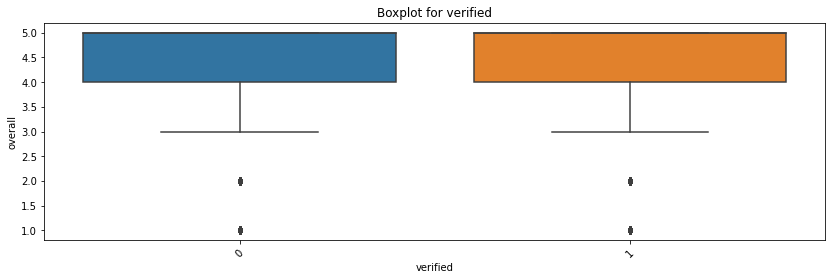

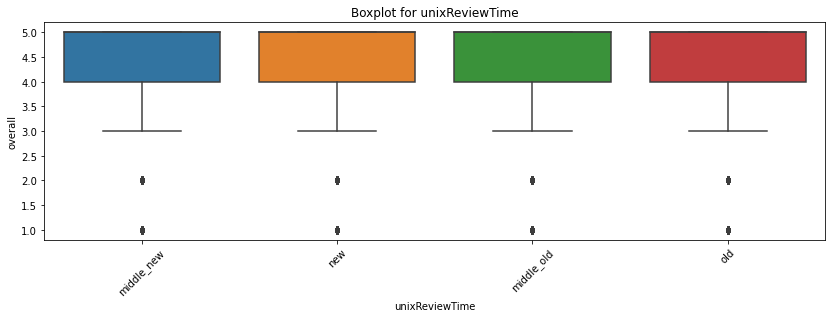

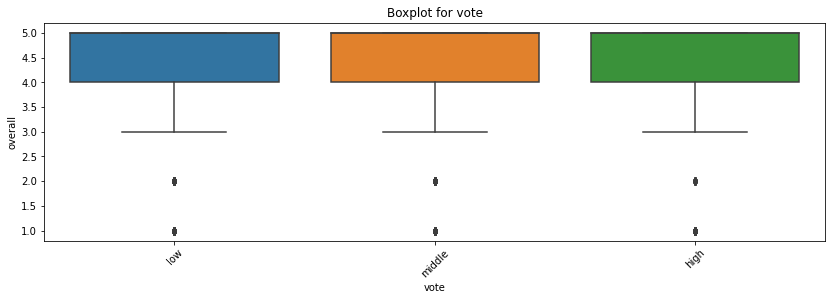

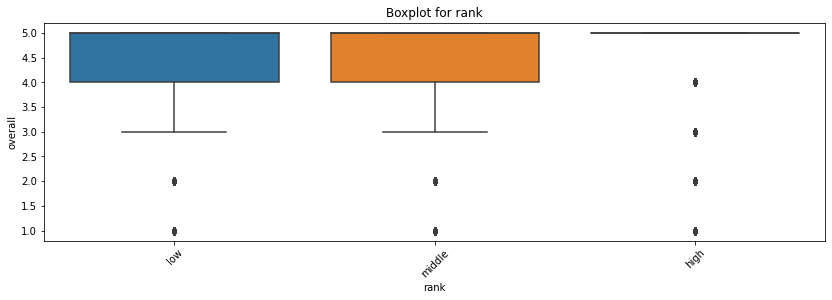

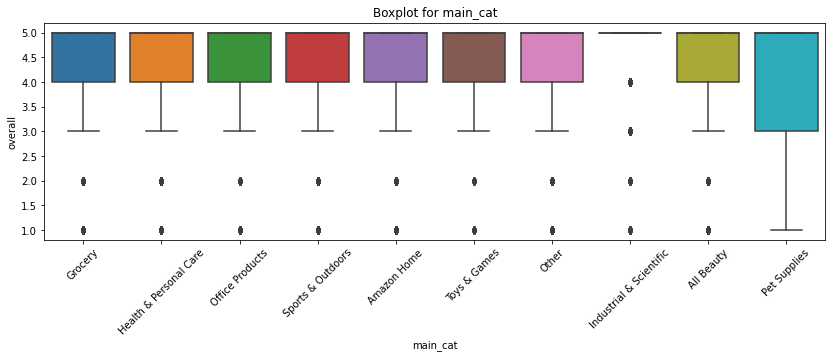

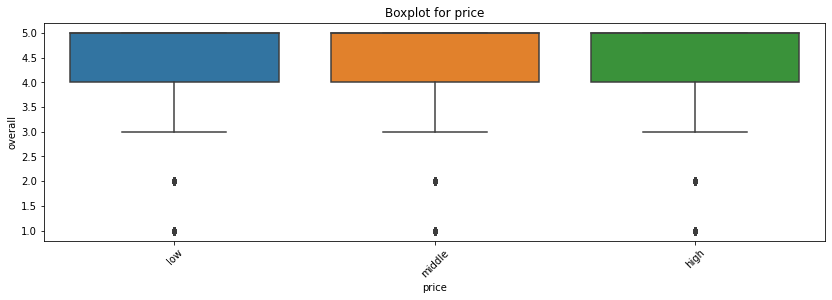

In [92]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_boxplot(col)

По графикам сильных различий не видно. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок пользователей по различным параметрам неразличимы:

In [93]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'overall'], 
                        df.loc[df.loc[:, column] == comb[1], 'overall']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [94]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки unixReviewTime
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Как мы видим, распределение оценок серьезно различается по всем шести параметрам.

Удалим признак overall

In [95]:
df = df.drop('overall', axis=1)

# Создадим dummy-переменные

Для verified dummy-переменные не нужны т.к. там и так бинарные значения.

In [96]:
# В процессе изучения документации пришло осознание, что dummy-переменные делать не обязательно, мы будем делать нечто похожее при создании item_features в отдельном ноутбуке.
'''for column in ['unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    dummies = pd.get_dummies(df[column], prefix = df[column].name)
    # Удаляем исходный столбец и добавляем dummies
    df = df.drop(df[column].name, axis=1).join(dummies)'''

"for column in ['unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:\n    dummies = pd.get_dummies(df[column], prefix = df[column].name)\n    # Удаляем исходный столбец и добавляем dummies\n    df = df.drop(df[column].name, axis=1).join(dummies)"

In [97]:
df.columns

Index(['verified', 'unixReviewTime', 'vote', 'userid', 'itemid', 'rating',
       'rank', 'main_cat', 'price'],
      dtype='object')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        847593 non-null  int64  
 1   unixReviewTime  847593 non-null  object 
 2   vote            847593 non-null  object 
 3   userid          847593 non-null  int64  
 4   itemid          847593 non-null  int64  
 5   rating          847593 non-null  float64
 6   rank            847593 non-null  object 
 7   main_cat        847593 non-null  object 
 8   price           847593 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 104.7+ MB


# Итоги EDA

Кратко напишем, что мы сделали с каждым признаком:

*  **overall**         - оценки от 1 до 5. Нет в тестовой выборке, использовали как вспомогательный признак для анализа.
*  **verified**        - привели значения к 0 и 1
*  **reviewTime**      - удалили признак т.к. есть unixReviewTime
*  **asin**            - удалили признак т.к. не использовали, хотя наверное могли бы для also_buy, also_view, similar_item
*  **reviewerName**    - удалили т.к. есть userid
*  **reviewText**      - выдилили самые часто встречающиеся слова, сделали (все подготовили и закомментировали для скорости) dummy-переменные. Но все оказалось зря т.к. признака нет в тестовой выборке
*  **summary**         - удалили т.к. нет в тестовом датасете
*  **unixReviewTime**  - сделали 4 категории в зависимости от даты отзыва, сделали dummy-переменные
*  **vote**            - сделали 3 категории в зависимости от количества голосов, сделали dummy-переменные
*  **style**           - удалили т.к. больше половины пропусков
*  **image_x**         - удалили
*  **userid**          - оставили для модели
*  **itemid**          - оставили для модели
*  **rating**          - оставили для модели - целевая переменная
*  **category**        - выдилили самые часто встречающиеся категории, сделали (все подготовили и закомментировали для скорости) dummy-переменные
*  **description**     - выдилили самые часто встречающиеся слова, сделали (все подготовили и закомментировали для скорости) dummy-переменные
*  **title**           - удалили т.к. сильно похож на description
*  **brand**           - выдилили самых часто встречающихся производителей, сделали (все подготовили и закомментировали для скорости) dummy-переменные
*  **rank**            - сделали 3 категории в зависимости от ранга, сделали dummy-переменные
*  **also_view**       - удалили, но наверное можно было бы использовать
*  **main_cat**        - сделали dummy-переменные
*  **price**           - сделали 3 категории в зависимости от цены, сделали dummy-переменные
*  **also_buy**        - удалили, но наверное можно было бы использовать
*  **image_y**         - удалили
*  **date**            - удалили
*  **feature**         - удалили
*  **details**         - удалили
*  **similar_item**    - удалили, но наверное можно было бы использовать. Много пропусков.
*  **tech1**           - удалили
*  **fit**             - удалили

В итоге получили большое количество признаков, которые можем использовать в нашей модели.

# Построение гибридной рекомендательной системы

Данный раздел вынесли в отдельный ноутбук т.к. добавление фичей результат не улучшило
https://www.kaggle.com/fedorazarov/project-20-group-1-fa

# Предсказания без использования фичей

In [99]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

Разделим тренировочный датасет на тренировочную и тестовую выборки

In [100]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

In [101]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))

Обучим модель

In [102]:
LR = 0.089
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

Получим предсказания

In [103]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Посчитаем метрику roc_auc_score

In [104]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)


0.7287024939593095

В качестве эксперимента создадим ещё одну модель, которую обучим на всем тренировочном датасете

In [105]:
# Создадим разреженную матрицу
ratings_coo2 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'],)))

# Обучим модель
model2 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model2 = model.fit(
    ratings_coo2,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

# Предсказание на тестовом датасете

Получим предсказания на тестовом датасете

In [106]:
preds = model.predict(test.userid.values,
                      test.itemid.values)
preds2 = model2.predict(test.userid.values,
                      test.itemid.values)

Нормализуем предсказания

In [107]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()


# Submission

In [108]:
submission['rating']= normalized_preds
submission.to_csv('submission_fastai.csv', index=False)

In [109]:
submission['rating']= normalized_preds2
submission.to_csv('submission_train_log.csv', index=False)

# Итоги работы

В результате мы провели подробный анализ данных, сгенерировали большое количество дополнительных признаков и познакомились с основными принципами работы рекомендательных систем. Также нам удалось улучшить baseline и получить значение rocauc выше 0.76.